In [11]:
import pandas as pd
import numpy as np

# Load the datasets
# Make sure these files are in the same directory as your script
patients_df = pd.read_csv('/kaggle/input/patients-data/patients.csv')
immunizations_df = pd.read_csv('/kaggle/input/patients-data/immunizations.csv')
allergies_df = pd.read_csv('/kaggle/input/patients-data/allergies.csv')

# Rename 'Id' to 'PATIENT' in the patients DataFrame for consistent merging
patients_df.rename(columns={'Id': 'PATIENT'}, inplace=True)

# Aggregate immunizations for each patient into a single string
immunizations_agg = immunizations_df.groupby('PATIENT')['DESCRIPTION'].apply(lambda x: ', '.join(x.unique())).reset_index()
immunizations_agg.rename(columns={'DESCRIPTION': 'Immunization Description'}, inplace=True)

# Aggregate allergies for each patient into a single string
allergies_agg = allergies_df.groupby('PATIENT')['DESCRIPTION'].apply(lambda x: ', '.join(x.unique())).reset_index()
allergies_agg.rename(columns={'DESCRIPTION': 'Allergy Description'}, inplace=True)

# Extract city, state, and country from the 'BIRTHPLACE' column
def extract_location(birthplace):
    parts = str(birthplace).split(', ')
    city = parts[0] if len(parts) > 0 else None
    state = parts[1] if len(parts) > 1 else None
    country = parts[2] if len(parts) > 2 else None
    return pd.Series([city, state, country])

patients_df[['city', 'state', 'country']] = patients_df['BIRTHPLACE'].apply(extract_location)

# Merge the dataframes
final_df = pd.merge(patients_df, immunizations_agg, on='PATIENT', how='left')
final_df = pd.merge(final_df, allergies_agg, on='PATIENT', how='left')

# Select the requested columns and create a proper copy to avoid warnings
final_df_subset = final_df[['PATIENT', 'GENDER', 'city', 'Immunization Description', 'Allergy Description']].copy()

# Rename columns for clarity
final_df_subset.rename(columns={'PATIENT': 'Patient ID', 'GENDER': 'Gender'}, inplace=True)

# Fill any patients without immunizations or allergies with "Unknown"
final_df_subset.fillna('Unknown', inplace=True)

# Display the first few rows of the final dataset
print(final_df_subset.head())

# Save the final dataset to a new CSV file
final_df_subset.to_csv('combined_patient_data.csv', index=False)

                             Patient ID Gender                           city  \
0  12bd34ca-7f50-b315-c17f-5c2cb502dc1b      M    Randolph  Massachusetts  US   
1  c193fd34-3fcf-a886-d11c-48b372362e87      M      Boston  Massachusetts  US   
2  41b77362-31fc-b380-9168-0d18d4913b18      F   Cambridge  Massachusetts  US   
3  1c97dda7-3ade-6ec6-38c0-131a7f6d7c01      M      Sharon  Massachusetts  US   
4  b2caeace-7bd2-8792-9a23-62b9cc8c99dd      F  Shutesbury  Massachusetts  US   

                            Immunization Description  \
0  Influenza  seasonal  injectable  preservative ...   
1  Influenza  seasonal  injectable  preservative ...   
2  Influenza  seasonal  injectable  preservative ...   
3  Influenza  seasonal  injectable  preservative ...   
4  Influenza  seasonal  injectable  preservative ...   

                                 Allergy Description  
0                                            Unknown  
1  Allergic disposition (finding), Tree pollen (s...  
2          

In [12]:
import os
print("Files in current directory:")
print(os.listdir('.'))

Files in current directory:
['combined_patient_data.csv', '.virtual_documents']


In [13]:
import os
print(f"File saved at: {os.path.abspath('combined_patient_data.csv')}")

File saved at: /kaggle/working/combined_patient_data.csv


In [22]:
import pandas as pd

# Load the medications dataset
medications_df = pd.read_csv('/kaggle/input/medication/medications.csv')

# Display basic info about medications dataset
print("Medications dataset shape:", medications_df.shape)
print("\nColumns in medications dataset:")
print(medications_df.columns.tolist())
print("\nFirst few rows of medications:")
print(medications_df.head())
print("\nSample REASONDESCRIPTION values:")
print(medications_df['REASONDESCRIPTION'].head(10))

# Aggregate medications reason descriptions for each patient
# Remove duplicates and join multiple reasons with commas
medications_agg = medications_df.groupby('PATIENT')['REASONDESCRIPTION'].apply(
    lambda x: ', '.join(x.dropna().unique())
).reset_index()
medications_agg.rename(columns={'REASONDESCRIPTION': 'Medication Reason Description'}, inplace=True)

print(f"\nAggregated medications for {len(medications_agg)} unique patients")
print("Sample aggregated medications:")
print(medications_agg.head())

# Load your existing combined dataset
try:
    # Try to load the most recent version
    combined_df = pd.read_csv('combined_patient_data.csv')
    print(f"\nLoaded existing combined dataset with {len(combined_df)} patients")
except FileNotFoundError:
    print("combined_patient_data.csv not found. Make sure you've run the main script first.")
    exit()

# Merge medications with the existing combined dataset
final_combined_df = pd.merge(combined_df, medications_agg, 
                            left_on='Patient ID', right_on='PATIENT', how='left')

# Drop the duplicate PATIENT column from medications
final_combined_df = final_combined_df.drop('PATIENT', axis=1)

# Fix the FutureWarning by using proper fillna method
final_combined_df = final_combined_df.fillna({'Medication Reason Description': 'Unknown'})

# Reorder columns to put medication columns at the end
base_columns = ['Patient ID', 'Gender', 'city', 'Immunization Description', 'Allergy Description']
medication_columns = ['Medication Reason Description']
final_combined_df = final_combined_df[base_columns + medication_columns]

print(f"\nFinal combined dataset shape: {final_combined_df.shape}")
print("\nFinal column names:")
print(final_combined_df.columns.tolist())

print("\nFirst few rows of final combined dataset:")
print("Dataset preview completed - check the saved CSV file for full data")

# Check for patients with medication data
patients_with_meds = (final_combined_df['Medication Reason Description'] != 'Unknown').sum()
print(f"\nPatients with medication data: {patients_with_meds}")
print(f"Patients without medication data: {len(final_combined_df) - patients_with_meds}")

# Save the updated combined dataset
final_combined_df.to_csv('combined_patient_data_with_medications.csv', index=False)
print("\nUpdated dataset saved as: combined_patient_data_with_medications.csv")

# Optional: If you want to overwrite the original file instead
# final_combined_df.to_csv('combined_patient_data.csv', index=False)
# print("\nOriginal combined_patient_data.csv updated with medications")

Medications dataset shape: (468761, 13)

Columns in medications dataset:
['START', 'STOP', 'PATIENT', 'PAYER', 'ENCOUNTER', 'CODE', 'DESCRIPTION', 'BASE_COST', 'PAYER_COVERAGE', 'DISPENSES', 'TOTALCOST', 'REASONCODE', 'REASONDESCRIPTION']

First few rows of medications:
                  START                  STOP  \
0  1994-02-18T14:36:13Z                   NaN   
1  1994-02-26T05:12:18Z                   NaN   
2  2015-03-20T03:26:36Z  2016-03-14T03:26:36Z   
3  2015-05-26T19:20:28Z  2016-05-20T19:20:28Z   
4  2016-05-20T19:20:28Z  2017-05-15T19:20:28Z   

                                PATIENT                                 PAYER  \
0  c3d3493a-8c90-f7b2-170b-6b7c16b8b192  e03e23c9-4df1-3eb6-a62d-f70f02301496   
1  c3d3493a-8c90-f7b2-170b-6b7c16b8b192  e03e23c9-4df1-3eb6-a62d-f70f02301496   
2  976ff1e2-1ccb-40cf-6a0e-d504d8af651e  d31fccc3-1767-390d-966a-22a5156f4219   
3  41b77362-31fc-b380-9168-0d18d4913b18  e03e23c9-4df1-3eb6-a62d-f70f02301496   
4  41b77362-31fc-b380-9168-0d

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



Aggregated medications for 5370 unique patients
Sample aggregated medications:
                                PATIENT  \
0  000d8a68-041e-c9f3-0de4-7b31521cb7a6   
1  002dd2a1-d86e-0136-17f7-c02fa19c763c   
2  00388b2a-3628-c92f-cfb3-38eb06de6bc6   
3  0044cfd5-cc77-7a88-ecd0-8835cc59e704   
4  004970d2-23d6-54e1-ea0f-04b104fcaaf2   

                       Medication Reason Description  
0  Patient referral for dental care (procedure), ...  
1  Acute bronchitis (disorder), Patient referral ...  
2  Patient referral for dental care (procedure), ...  
3  Localized  primary osteoarthritis of the hand ...  
4  Localized  primary osteoarthritis of the hand ...  

Loaded existing combined dataset with 5395 patients

Final combined dataset shape: (5395, 6)

Final column names:
['Patient ID', 'Gender', 'city', 'Immunization Description', 'Allergy Description', 'Medication Reason Description']

First few rows of final combined dataset:
Dataset preview completed - check the saved CSV file for

In [24]:
import os
print(f"File saved at: {os.path.abspath('combined_patient_data_with_medications.csv')}")

File saved at: /kaggle/working/combined_patient_data_with_medications.csv


In [30]:
import pandas as pd
import numpy as np
from datetime import datetime
import warnings

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# Suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None

# --- Load and Preprocess Data ---

# Load the combined dataset you created
try:
    combined_df = pd.read_csv('combined_patient_data_with_medications.csv')
    print("Loaded combined dataset with medications.")
except FileNotFoundError:
    print("Error: combined_patient_data_with_medications.csv not found.")
    print("Please make sure you have run your previous script to generate this file first.")
    exit()

# Display the first few rows of the loaded combined data
print("\nFirst 5 rows of the combined data:")
print(combined_df.head())

Loaded combined dataset with medications.

First 5 rows of the combined data:
                             Patient ID Gender                           city  \
0  12bd34ca-7f50-b315-c17f-5c2cb502dc1b      M    Randolph  Massachusetts  US   
1  c193fd34-3fcf-a886-d11c-48b372362e87      M      Boston  Massachusetts  US   
2  41b77362-31fc-b380-9168-0d18d4913b18      F   Cambridge  Massachusetts  US   
3  1c97dda7-3ade-6ec6-38c0-131a7f6d7c01      M      Sharon  Massachusetts  US   
4  b2caeace-7bd2-8792-9a23-62b9cc8c99dd      F  Shutesbury  Massachusetts  US   

                            Immunization Description  \
0  Influenza  seasonal  injectable  preservative ...   
1  Influenza  seasonal  injectable  preservative ...   
2  Influenza  seasonal  injectable  preservative ...   
3  Influenza  seasonal  injectable  preservative ...   
4  Influenza  seasonal  injectable  preservative ...   

                                 Allergy Description  \
0                                         

In [31]:
np.random.seed(42) # for reproducibility
combined_df['risk_in_90_days'] = np.random.choice([0, 1], size=len(combined_df), p=[0.85, 0.15])
print("\nSimulated a 'risk_in_90_days' target variable for modeling.")



Simulated a 'risk_in_90_days' target variable for modeling.


In [32]:
combined_df['Immunization Count'] = combined_df['Immunization Description'].apply(
    lambda x: len(str(x).split(', ')) if x != 'Unknown' else 0
)
combined_df['Allergy Count'] = combined_df['Allergy Description'].apply(
    lambda x: len(str(x).split(', ')) if x != 'Unknown' else 0
)
combined_df['Medication Reason Count'] = combined_df['Medication Reason Description'].apply(
    lambda x: len(str(x).split(', ')) if x != 'Unknown' else 0
)


In [33]:
# Identify features for the model
features = ['Gender', 'city', 'Immunization Count', 'Allergy Count', 'Medication Reason Count']

# One-hot encode categorical features on the full dataset to ensure alignment
X = pd.get_dummies(combined_df[features], columns=['Gender', 'city'], drop_first=True)
y = combined_df['risk_in_90_days']

# Handle any remaining missing values
X.fillna(0, inplace=True)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining model on {len(X_train)} samples and testing on {len(X_test)} samples.")


Training model on 4316 samples and testing on 1079 samples.


In [39]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# --- Generate Predictions and Output ---
# Predict probabilities for the test set
risk_probabilities = model.predict_proba(X_test)[:, 1]

# Create a DataFrame for the final output
test_patient_ids = combined_df.iloc[y_test.index]['Patient ID'].values
results_df = pd.DataFrame({
    'Patient ID': test_patient_ids,
    'Risk Factor Percentage': np.round(risk_probabilities * 100, 2)
})

# Assign a categorical risk level based on the probability
def assign_risk_level(score):
    if score >= 75:
        return 'Very High Risk'
    elif score >= 50:
        return 'High Risk'
    elif score >= 25:
        return 'Medium Risk'
    else:
        return 'Low Risk'

results_df['Risk Level'] = results_df['Risk Factor Percentage'].apply(assign_risk_level)

print("\nPatient Risk Predictions:")
print(results_df)

# Get the three columns and convert them to NumPy arrays
patient_ids_array = results_df['Patient ID'].to_numpy()
risk_percentage_array = results_df['Risk Factor Percentage'].to_numpy()
risk_level_array = results_df['Risk Level'].to_numpy()

# Combine them into a list of arrays
output_arrays = [patient_ids_array, risk_percentage_array, risk_level_array]

# Print the list of arrays
print("\nFinal Output as a list of NumPy arrays:")
print(output_arrays)

# Save the final output to a CSV file
results_df.to_csv('patient_risk_predictions.csv', index=False)
print("\nPrediction results saved to: patient_risk_predictions.csv")


Patient Risk Predictions:
                                Patient ID  Risk Factor Percentage  \
0     d8093acd-15af-0072-bb64-3ef87276e8ce               18.290001   
1     79e287e5-d908-89be-8b5e-c46435d7ddf9               10.120000   
2     c39924aa-31ba-acc8-31bf-68acc8937231               13.950000   
3     34f0967a-ffc4-1cac-369b-4ac0e6ed9fd6               13.950000   
4     937580b6-5192-f456-40ec-74bf806a3182               12.730000   
...                                    ...                     ...   
1074  a087fdb4-b6a1-4da5-4a9a-27094af18273               10.680000   
1075  aa0bb642-66f3-7a21-ce0e-8362c2fea704               13.950000   
1076  8ba63dc4-0011-6f5f-50e3-806de00d7d79               28.410000   
1077  6234cdec-77ae-5e81-7d7b-a1de0f882ca0                9.280000   
1078  3730d8a1-e118-f618-7ac6-5b25b363e77c               14.700000   

       Risk Level  
0        Low Risk  
1        Low Risk  
2        Low Risk  
3        Low Risk  
4        Low Risk  
...         

In [36]:
import os
print(f"File saved at: {os.path.abspath('patient_risk_predictions.csv')}")

File saved at: /kaggle/working/patient_risk_predictions.csv


/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)



Bar chart saved as 'patient_count_by_risk_level.png'
Box plot saved as 'risk_percentage_boxplot.png'


/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Histogram saved as 'risk_percentage_histogram.png'

All plots have been generated and saved.


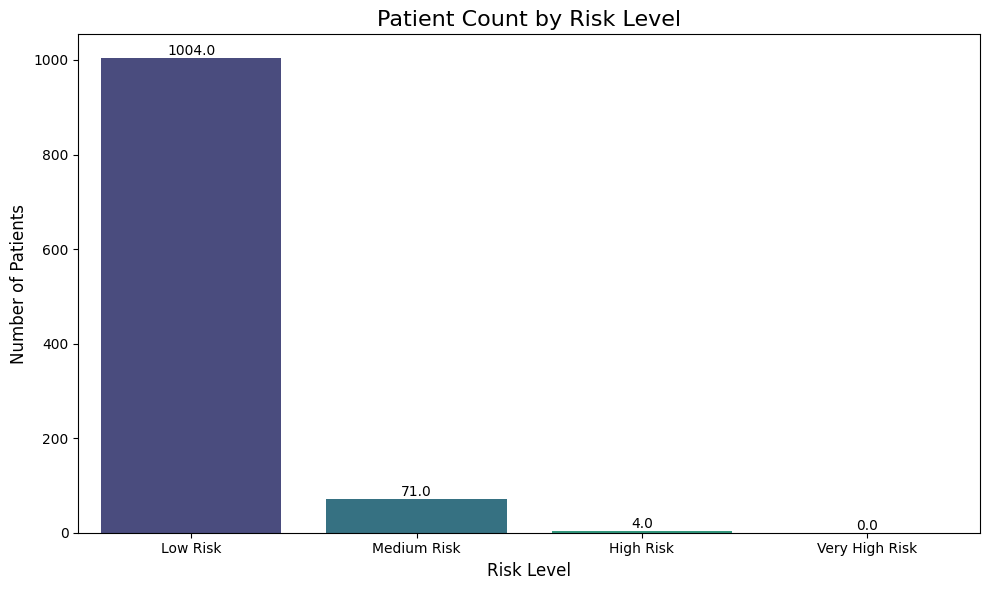

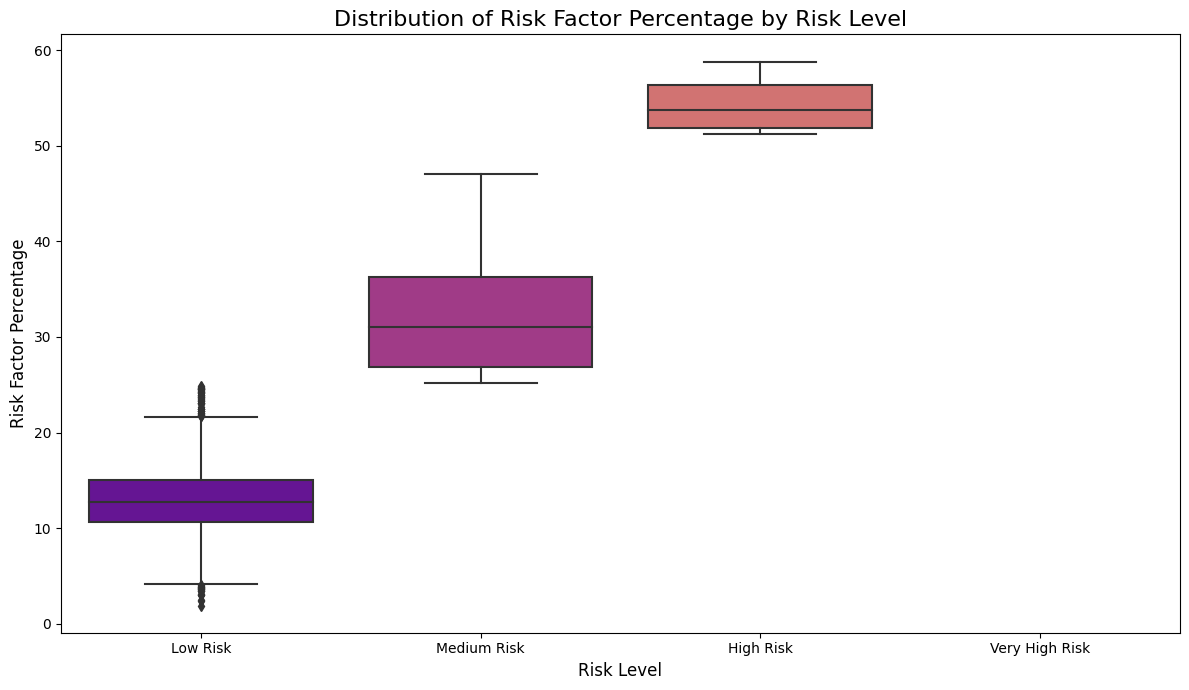

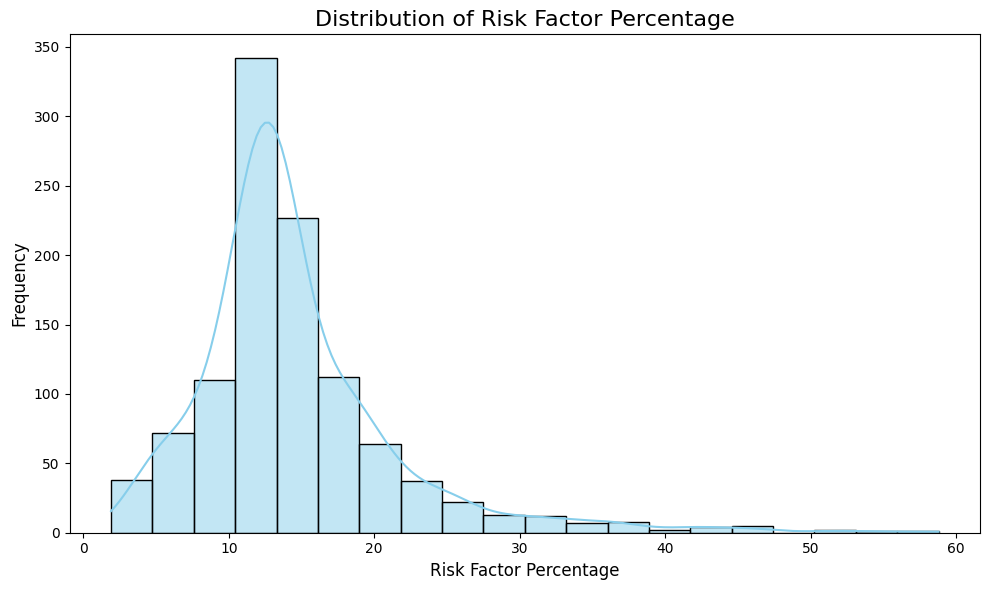

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

risk_order = ['Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk']
results_df['Risk Level'] = pd.Categorical(results_df['Risk Level'], categories=risk_order, ordered=True)

# Bar Chart of Patient Counts by Risk Level
plt.figure(figsize=(10, 6))
sns.countplot(x='Risk Level', data=results_df, palette='viridis', order=risk_order)
plt.title('Patient Count by Risk Level', fontsize=16)
plt.xlabel('Risk Level', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')
plt.tight_layout()
plt.savefig('patient_count_by_risk_level.png')
print("\nBar chart saved as 'patient_count_by_risk_level.png'")

# Box Plot of Risk Percentage by Risk Level
plt.figure(figsize=(12, 7))
sns.boxplot(x='Risk Level', y='Risk Factor Percentage', data=results_df, palette='plasma', order=risk_order)
plt.title('Distribution of Risk Factor Percentage by Risk Level', fontsize=16)
plt.xlabel('Risk Level', fontsize=12)
plt.ylabel('Risk Factor Percentage', fontsize=12)
plt.tight_layout()
plt.savefig('risk_percentage_boxplot.png')
print("Box plot saved as 'risk_percentage_boxplot.png'")

# Histogram of Risk Factor Percentage
plt.figure(figsize=(10, 6))
sns.histplot(results_df['Risk Factor Percentage'], bins=20, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Risk Factor Percentage', fontsize=16)
plt.xlabel('Risk Factor Percentage', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.savefig('risk_percentage_histogram.png')
print("Histogram saved as 'risk_percentage_histogram.png'")

print("\nAll plots have been generated and saved.")